<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4/blob/master/1_InitialModel_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
"""# Dataset and Creating Train/Test Split"""

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


In [4]:
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [5]:
"""# Dataloader Arguments & Test/Train Dataloaders"""

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


In [6]:

"""# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like
"""

# Commented out IPython magic to ensure Python compatibility.
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [7]:
print(train_data.shape)
type(train_data.shape)


torch.Size([28, 60000, 28])


torch.Size

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


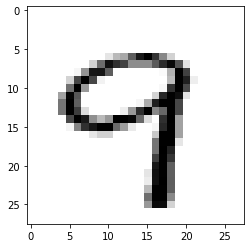

In [8]:
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
# %matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


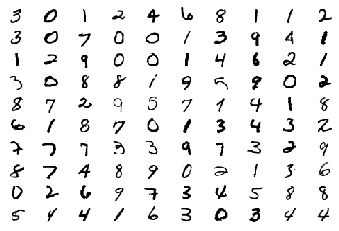

In [9]:

"""## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on
"""

figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:

"""# The model
Let's start with the model we first saw
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drpout = nn.Dropout(0.1)
		
        self.layer1 = nn.Sequential(
                nn.Conv2d(1,8,3,bias=False),
                nn.ReLU(),
                nn.BatchNorm2d(8),
                drpout
          )
        self.layer2 = nn.Sequential(
                nn.Conv2d(8,8,3,bias=False),
                nn.ReLU(),
                nn.BatchNorm2d(8),
                drpout
        )
        self.layer3_MP= nn.MaxPool2d(2,2)
        self.layer4 = nn.Sequential(		
                nn.Conv2d(8,16,3,bias=False),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                drpout
        )
        self.layer5 = nn.Sequential(
                nn.Conv2d(16,16,3),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                drpout
        )
        self.layer6_MP = nn.MaxPool2d(2,2)
        self.layer7 = nn.Sequential(
                nn.Conv2d(16,32,3,bias=False),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                drpout
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) 
        self.layer8 = nn.Sequential(
                nn.Conv2d(32,10,2,bias=False),
                #nn.ReLU()
        )
		
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3_MP(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6_MP(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [11]:

"""# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help
"""

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
           Dropout-5            [-1, 8, 26, 26]               0
           Dropout-6            [-1, 8, 26, 26]               0
           Dropout-7            [-1, 8, 26, 26]               0
           Dropout-8            [-1, 8, 26, 26]               0
            Conv2d-9            [-1, 8, 24, 24]             576
             ReLU-10            [-1, 8, 24, 24]               0
      BatchNorm2d-11            [-1, 8, 24, 24]              16
          Dropout-12            [-1, 8, 24, 24]               0
          Dropout-13            [-1, 8, 24, 24]               0
          Dropout-14            [-

In [0]:
"""# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions
"""

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
"""# Let's Train and test our model"""

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.04366007074713707 Batch_id=468 Accuracy=94.13: 100%|██████████| 469/469 [00:10<00:00, 43.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9834/10000 (98.34%)

EPOCH: 1


Loss=0.02578682266175747 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:10<00:00, 51.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.014044731855392456 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:11<00:00, 40.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.0780881866812706 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:11<00:00, 41.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.060452599078416824 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.044100645929574966 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.013040304183959961 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.018713587895035744 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.004758929368108511 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.016133293509483337 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 42.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.046288877725601196 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.028705229982733727 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

EPOCH: 12


Loss=0.0082086818292737 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.005550722125917673 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.011175503022968769 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:10<00:00, 43.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.007023001555353403 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:11<00:00, 42.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.006004894617944956 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 42.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.012294908054172993 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 44.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.08342209458351135 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.0021135311108082533 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:10<00:00, 43.97it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

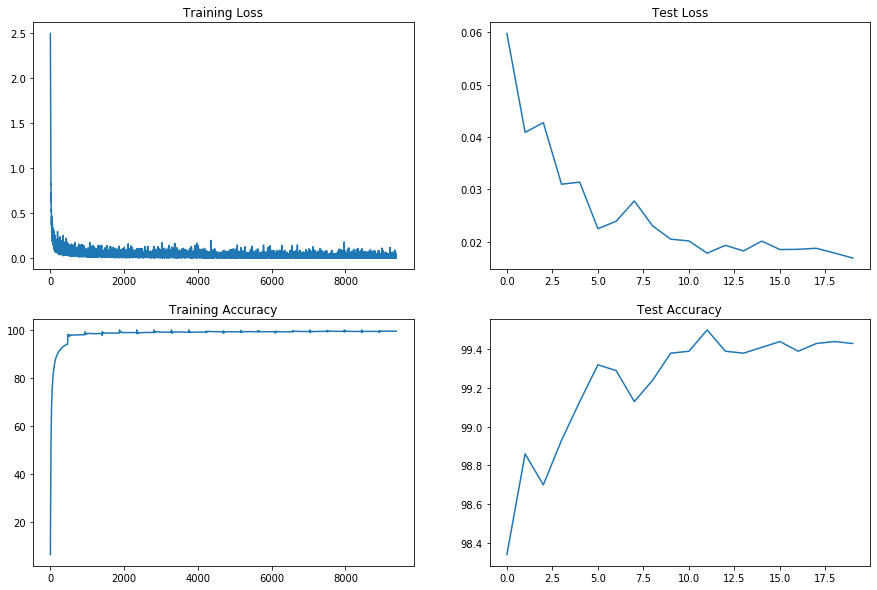

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")